In [5]:
import os, zipfile, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import kagglehub

In [4]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 5

In [6]:
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
if path.endswith(".zip"):
    with zipfile.ZipFile(path, "r") as z: z.extractall(path[:-4])
    path = path[:-4]

train_dir = os.path.join(path, "Train")

In [8]:
# Data (resize + normalize + augment)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10, width_shift_range=0.1,
    height_shift_range=0.1, zoom_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_flow = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training'
)
val_flow = val_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

num_classes = train_flow.num_classes

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [9]:
# Custom CNN
cnn_model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# MobileNetV2 (transfer learning)
base = MobileNetV2(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
base.trainable = False
mobilenet_model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/tmp/ipython-input-3141716637.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
print("\nTraining CNN...")
cnn_model.fit(train_flow, validation_data=val_flow, epochs=EPOCHS)

print("\nTraining MobileNetV2...")
mobilenet_model.fit(train_flow, validation_data=val_flow, epochs=EPOCHS)


Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 308s 311ms/step - accuracy: 0.3600 - loss: 2.2972 - val_accuracy: 0.7717 - val_loss: 0.7491
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 277s 283ms/step - accuracy: 0.8645 - loss: 0.4340 - val_accuracy: 0.8572 - val_loss: 0.5416
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 274s 279ms/step - accuracy: 0.9341 - loss: 0.2088 - val_accuracy: 0.9045 - val_loss: 0.4339
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 275s 281ms/step - accuracy: 0.9634 - loss: 0.1222 - val_accuracy: 0.8990 - val_loss: 0.4066
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 278s 283ms/step - accuracy: 0.9711 - loss: 0.0940 - val_accuracy: 0.9009 - val_loss: 0.4726

Training MobileNetV2...
Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 185s 183ms/step - accuracy: 0.4506 - loss: 1.9184 - val_accuracy: 0.4362 - val_loss: 2.0715
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 175s 179ms/step - accuracy: 0.6880 - loss: 0.9522 - val_accuracy: 0.4420 - val_loss: 2.0658
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 203s 180ms/step - a


CNN Validation Accuracy: 90.09%

CNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.80      0.86      0.83       444
           2       1.00      1.00      1.00       402
           3       0.95      0.84      0.89       264
           4       0.97      0.98      0.98       420
           5       1.00      0.97      0.99       432
           6       0.93      1.00      0.97       156
           7       0.92      0.75      0.83       126
           8       1.00      0.99      0.99        84
           9       1.00      1.00      1.00       222
          10       0.85      0.88      0.87       240
          11       0.95      1.00      0.98        42
          12       0.96      0.75      0.84       450
          13       0.84      0.58      0.69        72
          14       0.81      0.98      0.89        66
          15       1.00      1.00      1.00        78
          16       

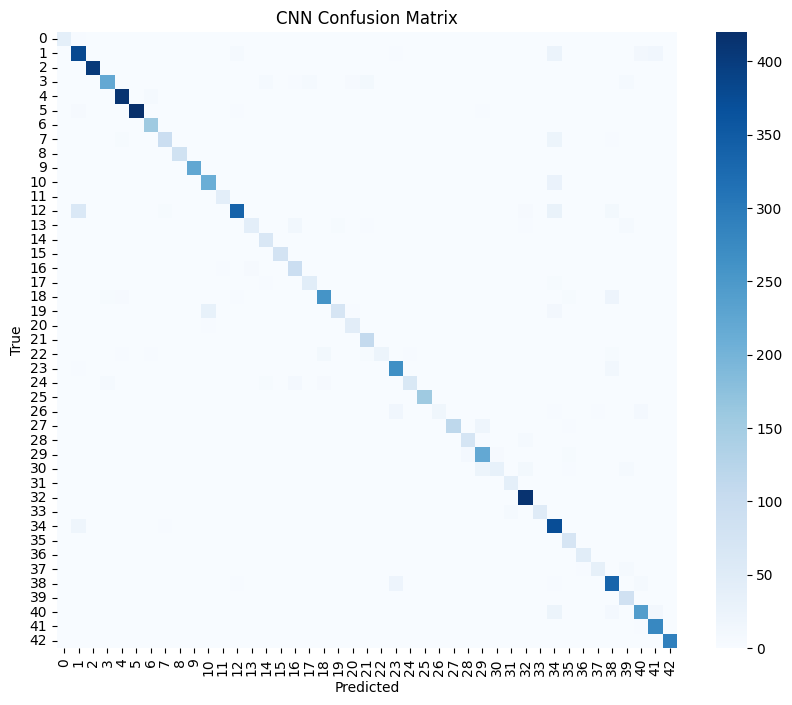


MobileNetV2 Validation Accuracy: 45.12%

MobileNetV2 Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.12      0.16        42
           1       0.29      0.17      0.21       444
           2       0.69      0.82      0.75       402
           3       0.21      0.33      0.26       264
           4       0.80      0.84      0.82       420
           5       0.81      0.84      0.82       432
           6       0.92      0.96      0.94       156
           7       0.85      0.62      0.72       126
           8       0.57      0.48      0.52        84
           9       0.81      0.83      0.82       222
          10       0.41      0.38      0.39       240
          11       0.05      0.10      0.07        42
          12       0.28      0.47      0.35       450
          13       0.12      0.04      0.06        72
          14       0.23      0.14      0.17        66
          15       0.00      0.00      0.00        78
   

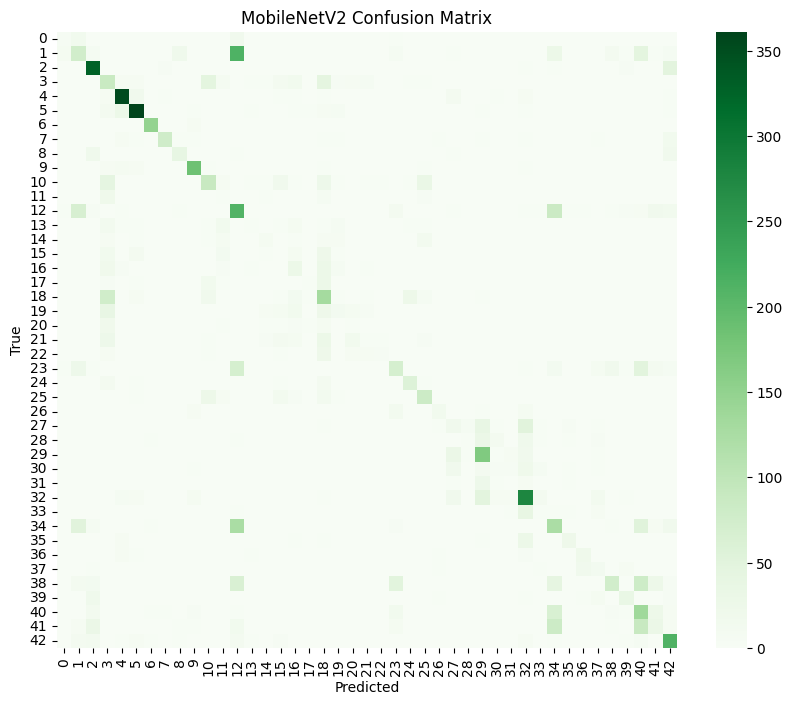

In [12]:
# Evaluate + Confusion Matrix
def eval_and_plot(model, val_gen, title, cmap):
    loss, acc = model.evaluate(val_gen, verbose=0)
    print(f"\n{title} Validation Accuracy: {acc*100:.2f}%")

    y_true = val_gen.classes
    y_pred = np.argmax(model.predict(val_gen, verbose=0), axis=1)

    print(f"\n{title} Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8)); sns.heatmap(cm, annot=False, cmap=cmap)
    plt.title(f"{title} Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

eval_and_plot(cnn_model, val_flow, "CNN", "Blues")
eval_and_plot(mobilenet_model, val_flow, "MobileNetV2", "Greens")